# Has Bhutan's Policy of Gross National Happiness (GNH) encouraged a more sustainable economy or improved its citizens well being?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('data.csv') #src: https://databank.worldbank.org/reports.aspx
#df_large = pd.read_csv('data_large.csv') #src: https://databank.worldbank.org/reports.aspx

Data was retrieved manually from The World Bank's Data Bank. One dataset (`data.csv`) is comprised of manually selected features, the other (`data_large.csv`) includes all the non-leaky features available. In the end, the smaller, curated dataset was used, as it avoids GNH being implicitly controlled for, through some of the features.

## Data Cleaning

In [2]:
df.drop(columns=['Series Code', 'Country Code'], inplace=True)
df_large.drop(columns=['Series Code', 'Country Code'], inplace=True)
target = 'CO2 emissions (kt)' #'Total greenhouse gas emissions (kt of CO2 equivalent)'
def pivot(df, target):
    columns = ['Country Name']
    columns += df['Series Name'].unique().tolist()[:-3]
    _ = df.pivot_table(index='Country Name',values=target,aggfunc=list).squeeze()
    df = pd.DataFrame(_.tolist(),index=_.index).reset_index()
    df.columns = columns
    return df

def impute(df, row_threshold=0.5, column_threshold=0.2, target=target):
    global n_imputed, pct_imputed, columns_dropped, columns_imputed, rows_dropped
    df.set_index('Country Name',inplace=True)
    df.replace('..',np.nan,inplace=True)
    df = df.drop(df[df[target].isna()].index)
    df = df.apply(pd.to_numeric)
    _ = df.isna().mean(axis=1)
    rows_dropped = _[_ > row_threshold].index
    df = df.drop(rows_dropped)
    _ = df.isna().mean()
    columns_dropped = _[_ > column_threshold].index
    df = df.drop(columns=columns_dropped)
    columns_imputed = _[(_ > 0) & (_ < column_threshold)].index
    n_imputed = df[columns_imputed].isna().sum()
    pct_imputed = n_imputed/len(df)
    for column in df.columns:
        df[column] = df[column].fillna(df[column].mean())
    return df
df = pivot(df, '2014 [YR2014]')
df = impute(df)

The dataset is reformatted and cleaned and missing data is mean-imputed according to a custom function. Countries with a missing target value are dropped first, then countries with <50% data are dropped, then features with little <20% data are dropped, and finally the remaining missing values are mean-imputed.

## Model Creation

In [3]:
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
X = df.drop(columns=[target,'Total greenhouse gas emissions (kt of CO2 equivalent)'])
y = np.log1p(df[target])
LOO = LeaveOneOut()
xgb = make_pipeline(StandardScaler(), XGBRegressor())
linear = make_pipeline(StandardScaler(), LinearRegression())
ridge = make_pipeline(StandardScaler(), Ridge(alpha=1))
results = df[[target]]
results.columns = ['Actual']
xgb_preds = []
feature_importances = []
linear_preds = []
ridge_preds = []

for train_index, test_index in LOO.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb.fit(X_train, y_train)
    y_pred = np.expm1(xgb.predict(X_test)[0])
    xgb_preds.append(y_pred)
    feature_importances.append(xgb.steps[1][1].feature_importances_)

    linear.fit(X_train, y_train)
    y_pred = np.expm1(linear.predict(X_test)[0])
    linear_preds.append(y_pred)

    ridge.fit(X_train, y_train)
    y_pred = np.expm1(ridge.predict(X_test)[0])
    ridge_preds.append(y_pred)

feature_importance = np.mean(feature_importances, axis=0)

results.insert(len(results.columns), 'XGB', xgb_preds, True)
results.insert(len(results.columns), 'Linear', linear_preds, True)
results.insert(len(results.columns), 'Ridge', ridge_preds, True)

results.insert(len(results.columns), 'XGB Error', results['Actual'] - results['XGB'], True)
results.insert(len(results.columns), 'Linear Error', results['Actual'] - results['Linear'], True)
results.insert(len(results.columns), 'Ridge Error', results['Actual'] - results['Ridge'], True)

Three seperate models are trained: An `XGBRegressor`, a `LinearRegression`, and a `Ridge` regression. In each instance, models are trained using a `LeaveOneOut` split, such that each country is assigned with a non-leaky error value by each model. Error values are collected, alongside the country they relate to.

In [4]:
results.head()

,Actual,XGB,Linear,Ridge,XGB Error,Linear Error,Ridge Error
Country Name,,,,,,,
Afghanistan,9281.340,8323.961914,3196.183529,3184.351200,957.378086,6085.156471,6096.988800
Albania,5188.000,5346.522949,10336.618445,10199.420596,-158.522949,-5148.618445,-5011.420596
Algeria,147735.200,120875.328125,874907.088205,871108.211563,26859.871875,-727171.888205,-723373.011563
Andorra,461.664,557.353455,1320.767492,1350.278074,-95.689455,-859.103492,-888.614074
Angola,29610.500,60795.031250,5283.821676,5331.052777,-31184.531250,24326.678324,24279.447223


## Results Visulisation

In [5]:
xgb_mae = np.absolute(results['XGB Error']).mean()
linear_mae = np.absolute(results['Linear Error']).mean()
ridge_mae = np.absolute(results['Ridge Error']).mean()
print(f'XGB: {round(xgb_mae):,} Linear:{round(linear_mae):,} Ridge:{round(ridge_mae):,}')
from sklearn.metrics import r2_score as r2
xgb_r2 = r2(results['Actual'],results['XGB'])
linear_r2 = r2(results['Actual'],results['Linear'])
ridge_r2 = r2(results['Actual'],results['Ridge'])
print(f'XGB: {round(xgb_r2,2):,} Linear:{round(linear_r2,2):,} Ridge:{round(ridge_r2,2):,}')

XGB: 116,680 Linear:1,327,091,867,352 Ridge:644,700,306,066
XGB: 0.46 Linear:-451,177,085,387,583.06 Ridge:-106,478,554,405,189.55


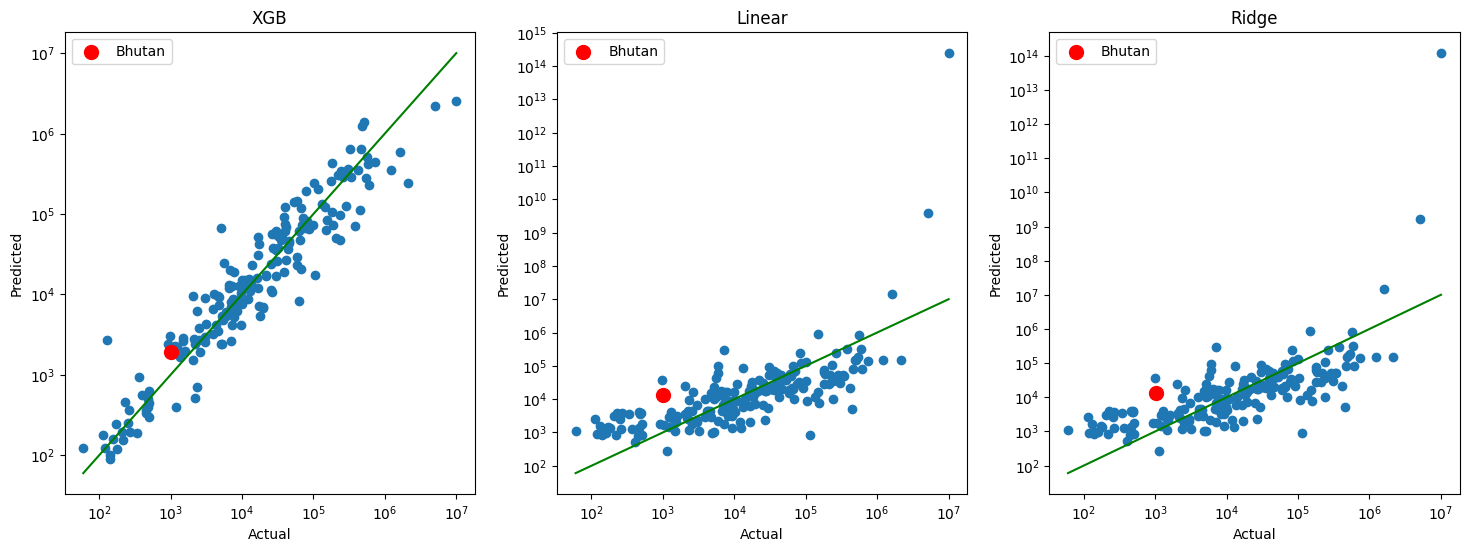

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
line = np.linspace(min(results['Actual']), max(results['Actual']))
bhutan = 'Bhutan'
bhutan_row = results[results.index == bhutan]

axs[0].scatter(results['Actual'],results['XGB'])
axs[0].set_title('XGB')
axs[0].scatter(bhutan_row['Actual'], bhutan_row['XGB'], color='red', s=100, label=bhutan)

axs[1].scatter(results['Actual'],results['Linear'])
axs[1].set_title('Linear')
axs[1].scatter(bhutan_row['Actual'], bhutan_row['Linear'], color='red', s=100, label=bhutan)

axs[2].scatter(results['Actual'],results['Ridge'])
axs[2].set_title('Ridge')
axs[2].scatter(bhutan_row['Actual'], bhutan_row['Ridge'], color='red', s=100, label=bhutan)

for ax in axs:
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.plot(line,line,color='green')
    ax.legend()

plt.show()

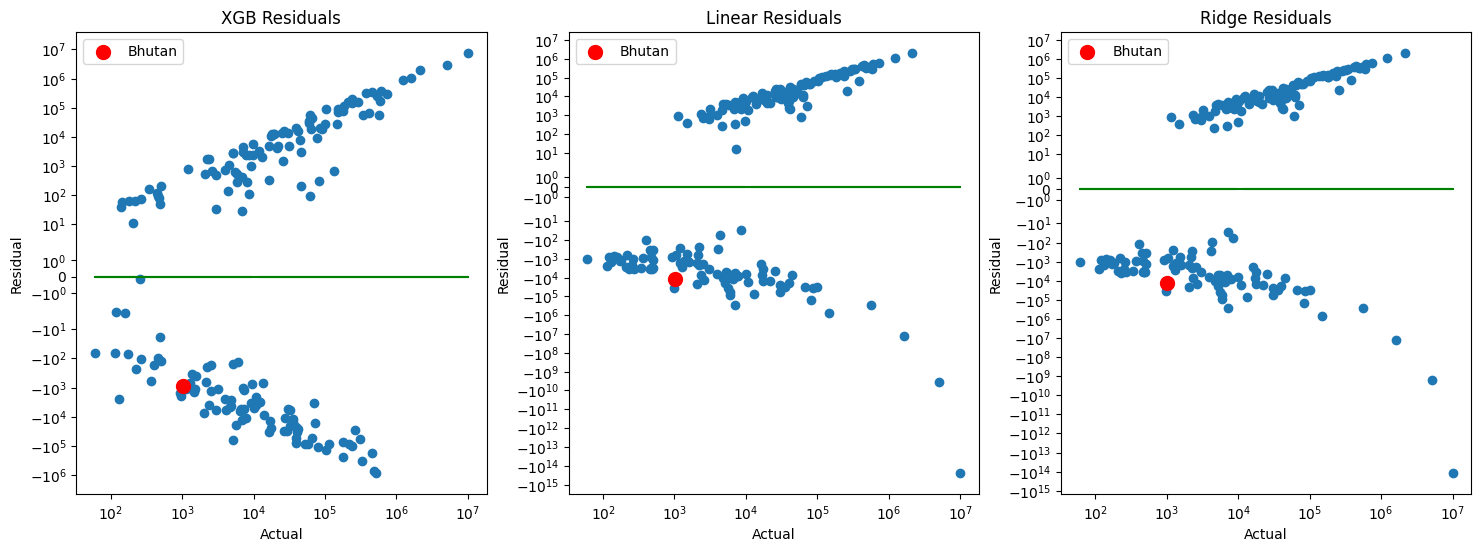

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
zero_line = np.zeros_like(results['Actual'])

axs[0].scatter(results['Actual'], results['XGB Error'])
axs[0].set_title('XGB Residuals')
axs[0].scatter(bhutan_row['Actual'], bhutan_row['XGB Error'], color='red', s=100, label=bhutan)

axs[1].scatter(results['Actual'], results['Linear Error'])
axs[1].set_title('Linear Residuals')
axs[1].scatter(bhutan_row['Actual'], bhutan_row['Linear Error'], color='red', s=100, label=bhutan)

axs[2].scatter(results['Actual'], results['Ridge Error'])
axs[2].set_title('Ridge Residuals')
axs[2].scatter(bhutan_row['Actual'], bhutan_row['Ridge Error'], color='red', s=100, label=bhutan)

for ax in axs:
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Residual')
    ax.plot(results['Actual'], zero_line, color='green')
    ax.legend()

plt.show()

The relusts are displayed using Actual vs. Predicted plots, and residual plots. In each one Bhutan is highlighted. Bhutan's emissions are consistently over-predicted. However, in the case of `Ridge` and `LinearRegression`, this is due to a bias in which most small countries' emissions are overpredicted. `XGBRegressor` looks like a clear winner out of the three models.

## Selection of XGB and Conclusion

In [8]:
pd.DataFrame([X.columns,feature_importance]).T

,0,1
0,GDP (constant 2015 US$),0.637207
1,"Population, total",0.017268
2,Land area (sq. km),0.007768
3,"Industry (including construction), value added...",0.011907
4,"Manufacturing, value added (% of GDP)",0.005771
5,"Services, value added (% of GDP)",0.003436
6,"Agriculture, forestry, and fishing, value adde...",0.00523
7,Rural population,0.012334
8,Urban population,0.276272
9,"Life expectancy at birth, total (years)",0.01381


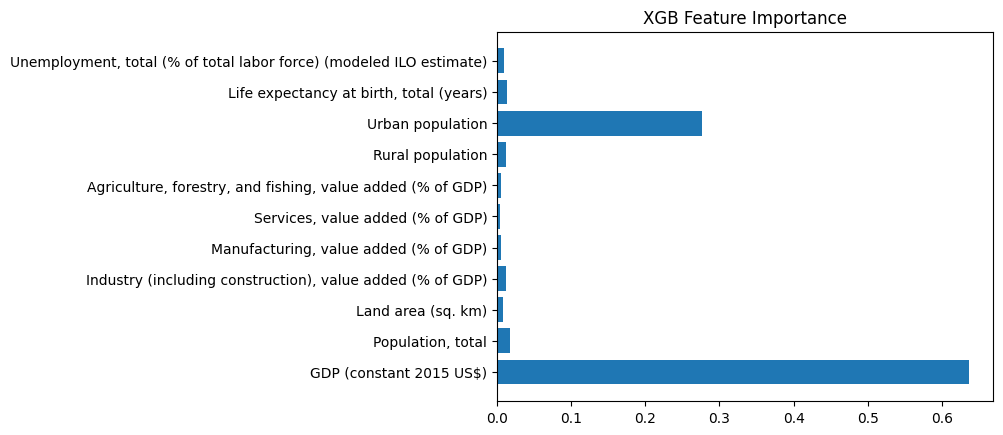

In [9]:
plt.barh(X.columns,feature_importance)
plt.title('XGB Feature Importance')
plt.show()

In [10]:
bhutan_actual = results.loc[bhutan, 'XGB Error']
mean_actual = results['XGB Error'].mean()
std_actual = results['XGB Error'].std()
bhutan_z_score = (bhutan_actual - mean_actual) / std_actual
bhutan_z_score

-0.1205422441745918

Unsurprisingly, GDP, was the most important feature in predicting CO2. Bhutan had a Z score of -0.21, making it not  a significant outlier.

## Repeating The Analysis for Wellbeing

In [11]:
wellbeing_df = pd.read_csv('2016.csv')[['Country','Happiness Score']]
wellbeing_df.columns = ['Country Name', 'Happiness']

X = pd.merge(df, wellbeing_df, on="Country Name").set_index('Country Name').drop(columns=['Happiness'])
y = pd.merge(df, wellbeing_df, on="Country Name")['Happiness']
LOO = LeaveOneOut()
xgb = make_pipeline(StandardScaler(), XGBRegressor())
linear = make_pipeline(StandardScaler(), LinearRegression())
ridge = make_pipeline(StandardScaler(), Ridge(alpha=2))
results_ = pd.merge(df, wellbeing_df, on="Country Name").set_index('Country Name')[['Happiness']]
results_.columns = ['Actual']
xgb_preds = []
feature_importances = []
linear_preds = []
ridge_preds = []

for train_index, test_index in LOO.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)[0]
    xgb_preds.append(y_pred)
    feature_importances.append(xgb.steps[1][1].feature_importances_)

    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)[0]
    linear_preds.append(y_pred)

    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)[0]
    ridge_preds.append(y_pred)

feature_importance = np.mean(feature_importances, axis=0)

results_.insert(len(results_.columns), 'XGB', xgb_preds, True)
results_.insert(len(results_.columns), 'Linear', linear_preds, True)
results_.insert(len(results_.columns), 'Ridge', ridge_preds, True)

results_.insert(len(results_.columns), 'XGB Error', results_['Actual'] - results_['XGB'], True)
results_.insert(len(results_.columns), 'Linear Error', results_['Actual'] - results_['Linear'], True)
results_.insert(len(results_.columns), 'Ridge Error', results_['Actual'] - results_['Ridge'], True)

In [12]:
xgb_mae = np.absolute(results_['XGB Error']).mean()
linear_mae = np.absolute(results_['Linear Error']).mean()
ridge_mae = np.absolute(results_['Ridge Error']).mean()
print(f'XGB: {round(xgb_mae,2):,} Linear:{round(linear_mae,2):,} Ridge:{round(ridge_mae,2):,}')

xgb_r2 = r2(results_['Actual'], results_['XGB'])
linear_r2 = r2(results_['Actual'], results_['Linear'])
ridge_r2 = r2(results_['Actual'], results_['Ridge'])
print(f'XGB: {round(xgb_r2,2):,} Linear:{round(linear_r2,2):,} Ridge:{round(ridge_r2,2):,}')

XGB: 0.56 Linear:0.51 Ridge:0.48
XGB: 0.64 Linear:0.67 Ridge:0.74


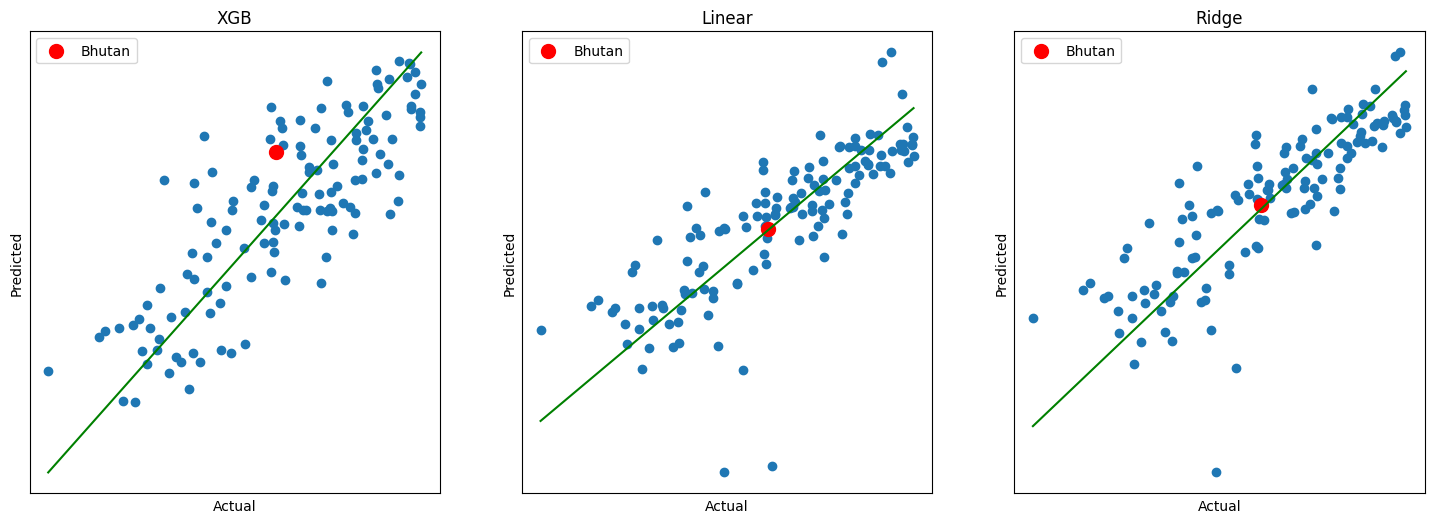

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
line = np.linspace(min(results_['Actual']), max(results_['Actual']))
bhutan = 'Bhutan'
bhutan_row = results_[results_.index == bhutan]

axs[0].scatter(results_['Actual'], results_['XGB'])
axs[0].set_title('XGB')
axs[0].scatter(bhutan_row['Actual'], bhutan_row['XGB'], color='red', s=100, label=bhutan)

axs[1].scatter(results_['Actual'], results_['Linear'])
axs[1].set_title('Linear')
axs[1].scatter(bhutan_row['Actual'], bhutan_row['Linear'], color='red', s=100, label=bhutan)

axs[2].scatter(results_['Actual'], results_['Ridge'])
axs[2].set_title('Ridge')
axs[2].scatter(bhutan_row['Actual'], bhutan_row['Ridge'], color='red', s=100, label=bhutan)

for ax in axs:
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.plot(line, line, color='green')
    ax.legend()

plt.show()

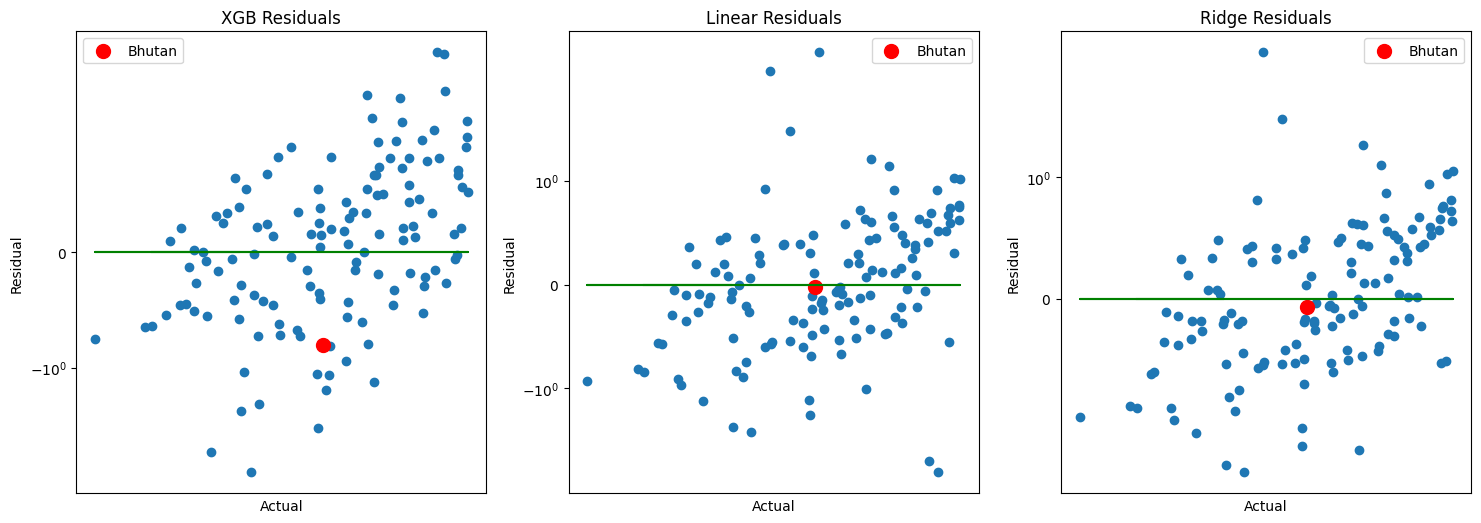

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
zero_line = np.zeros_like(results_['Actual'])

axs[0].scatter(results_['Actual'], results_['XGB Error'])
axs[0].set_title('XGB Residuals')
axs[0].scatter(bhutan_row['Actual'], bhutan_row['XGB Error'], color='red', s=100, label=bhutan)

axs[1].scatter(results_['Actual'], results_['Linear Error'])
axs[1].set_title('Linear Residuals')
axs[1].scatter(bhutan_row['Actual'], bhutan_row['Linear Error'], color='red', s=100, label=bhutan)

axs[2].scatter(results_['Actual'], results_['Ridge Error'])
axs[2].set_title('Ridge Residuals')
axs[2].scatter(bhutan_row['Actual'], bhutan_row['Ridge Error'], color='red', s=100, label=bhutan)

for ax in axs:
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Residual')
    ax.plot(results_['Actual'], zero_line, color='green')
    ax.legend()

plt.show()


In [15]:
bhutan_actual = results_.loc[bhutan, 'Ridge Error']
mean_actual = results_['Ridge Error'].mean()
std_actual = results_['Ridge Error'].std()
bhutan_z_score = (bhutan_actual - mean_actual) / std_actual
bhutan_z_score

-0.11620642766163695

#### Investigating CO2 Residuals

In [16]:
import plotly.express as px

fig = px.choropleth(results, locations=results.index, locationmode='country names', color='XGB Error', hover_name=results.index,
                    projection='natural earth', title='CO2 Error by Country', color_continuous_midpoint=0)
fig.show()